# References
This notebook is heavily based on the excellent ``Practical RL'' course from the Yandex
School of Data Analysis
https://github.com/yandexdataschool/Practical_RL/

# Crossentropy method

This notebook will teach you to solve reinforcement learning with crossentropy method.

In [1]:
#XVFB will be launched if you run on a server
import os
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY"))==0:
    !bash ../xvfb start
    %env DISPLAY=:1

In [2]:
import gym
import numpy as np, pandas as pd
import matplotlib.pyplot as plt

env = gym.make("Taxi-v2")
env.reset()
env.render()

[2017-07-24 10:41:23,471] Making new env: Taxi-v2


+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



In [3]:
n_states = env.observation_space.n
n_actions = env.action_space.n

print("n_states=%i, n_actions=%i"%(n_states,n_actions))

n_states=500, n_actions=6


# Create stochastic policy

This time our policy should be a probability distribution.

```policy[s,a] = P(take action a | in state s)```

Since we still use integer state and action representations, you can use a 2-dimensional array to represent the policy.

Please initialize policy __uniformly__, that is, probabililities of all actions should be equal.


In [4]:
policy = np.ones((n_states,n_actions))/n_actions

In [5]:
# "assert" is used to debug
assert type(policy) in (np.ndarray,np.matrix)
assert np.allclose(policy,1./n_actions)
assert np.allclose(np.sum(policy,axis=1), 1)

# Play the game

Just like before, but we also record all states and actions we took.

In [6]:
def generate_session(t_max=10**4):
    """
    Play game until end or for t_max ticks.
    returns: list of states, list of actions and sum of rewards
    """
    states,actions = [],[]
    total_reward = 0.
    
    s = env.reset()
    
    for t in range(t_max):
        #env.render()
        #<pick action from policy (at random with probabilities)>
        ###
        a = np.random.choice(6, p = policy[s])
        ###
        
        new_s,r,done,info = env.step(a)
        
        #<record prev state, action and add up reward to states,
        # actions and total_reward accordingly>
        ###
        states.append(s)
        actions.append(a)
        total_reward += r
        ###
        
        s = new_s
        if done:
            break
    return states,actions,total_reward,t

In [7]:
s,a,r,t = generate_session()
assert type(s) == type(a) == list
assert len(s) == len(a)
assert type(r) is float
print(r,t)

-830.0 199


# Training loop
Generate sessions, select N best and fit to those.

In [47]:
n_samples = 300  #sample this many samples
percentile = 50  #take this percent of session with highest rewards
smoothing = 0.1  #add this thing to all counts for stability
policy = np.ones((n_states,n_actions))/n_actions #need to reset the policy when changing hyperparameters
reward_distribution = []
thresholds = []

for i in range(20):
    
    sessions = [generate_session() for i in range(n_samples)]
    
    batch_states,batch_actions,batch_rewards,timestep = map(np.array,zip(*sessions))

    #batch_states: a list of lists of states in each session
    #batch_actions: a list of lists of actions in each session
    #batch_rewards: a list of floats - total rewards at each session
    
    threshold = np.percentile(batch_rewards, q=100-percentile)
    
    elite_states = batch_states[batch_rewards>threshold]
    elite_actions = batch_actions[batch_rewards>threshold]
    
    elite_states, elite_actions = map(np.concatenate,[elite_states,elite_actions])
    #hint on task above: use np.percentile and numpy-style indexing
    
    #count actions from elite states
    elite_counts = np.zeros_like(policy)+smoothing
    
    #<count all state-action occurences in elite_states and elite_actions>
    for state,action in zip(elite_states,elite_actions):
        elite_counts[state,action]+=1.
    
    #improve the policy
    for state in elite_states:
        policy[state] = elite_counts[state] / sum(elite_counts[state])
       
    print("mean reward = %.5f\tthreshold = %.1f"%(np.mean(batch_rewards),threshold))
    
    """#show the distribution of rewards
    if i % 10 == 0 or i == 99:
        print("iteration",i)
        print("mean reward = %.5f\tthreshold = %.1f"%(np.mean(batch_rewards),threshold))
        print("rewards above +9.0 is",(batch_rewards>9.).sum()/len(batch_rewards)*100,"%")
        plt.hist(timestep,bins=100)
        plt.show()"""

    reward_distribution.append(batch_rewards)
    thresholds.append(threshold)

mean reward = -762.39333	threshold = -785.0
mean reward = -697.70667	threshold = -726.5
mean reward = -619.01000	threshold = -659.0
mean reward = -559.09000	threshold = -596.0
mean reward = -456.55000	threshold = -506.0
mean reward = -340.98667	threshold = -339.0
mean reward = -208.41000	threshold = -186.0
mean reward = -124.03667	threshold = -106.0
mean reward = -79.79333	threshold = -64.5
mean reward = -46.82667	threshold = -38.0
mean reward = -30.77667	threshold = -23.0
mean reward = -20.42333	threshold = -15.0
mean reward = -11.82000	threshold = -7.0
mean reward = -10.67000	threshold = -6.0
mean reward = -7.95000	threshold = -5.0
mean reward = -6.04000	threshold = -2.0
mean reward = -4.22000	threshold = 0.0
mean reward = -2.69000	threshold = 1.0
mean reward = -3.69667	threshold = 1.0
mean reward = -1.67333	threshold = 3.0


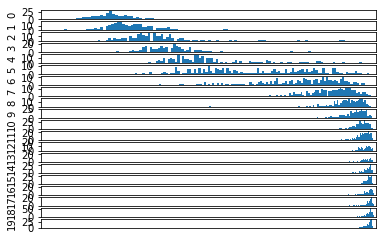

In [58]:
for i,reward in enumerate(reward_distribution):
    plt.subplot(20, 1, i+1)
    plt.ylabel(i)
    
    plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off')
    
    plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off')
    
    plt.xlim(-1000,20)
    plt.hist(reward,bins=100)

plt.show()

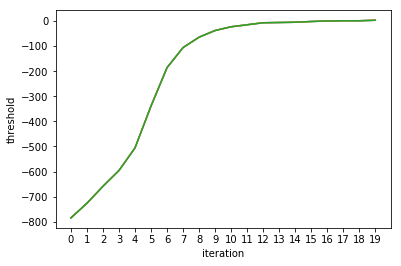

In [63]:
plt.plot(np.arange(20),thresholds)
plt.xticks(np.arange(20))
plt.xlabel("iteration")
plt.ylabel("threshold")
plt.show()

In [30]:
go = reward_distribution[19]
goku = []
for g in go:
    if g > -200:
        goku.append(g)
print(np.mean(goku))

-17.5112359551


percentile= 10 %
mean reward = -96.77600	threshold = 10.0
rewards above +9.0 is 11.2 %


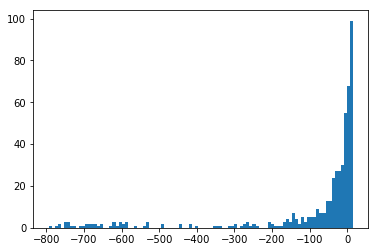

percentile= 20 %
mean reward = -21.94400	threshold = 9.0
rewards above +9.0 is 15.4 %


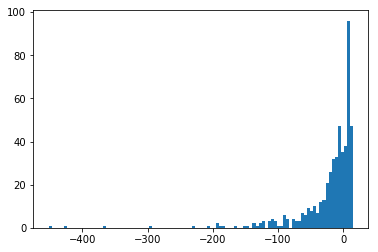

percentile= 30 %
mean reward = -8.03000	threshold = 7.0
rewards above +9.0 is 16.8 %


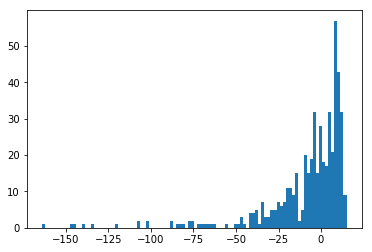

percentile= 40 %
mean reward = -1.05200	threshold = 7.0
rewards above +9.0 is 16.8 %


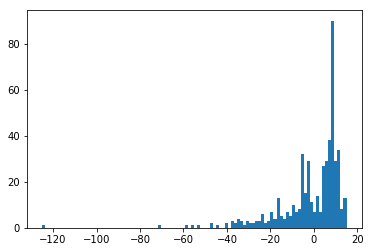

percentile= 50 %
mean reward = 1.48200	threshold = 5.5
rewards above +9.0 is 19.0 %


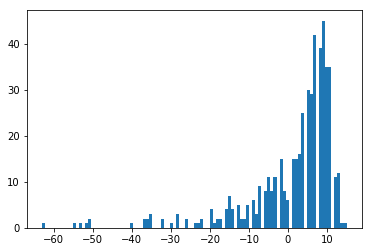

percentile= 60 %
mean reward = 2.71800	threshold = 5.0
rewards above +9.0 is 19.2 %


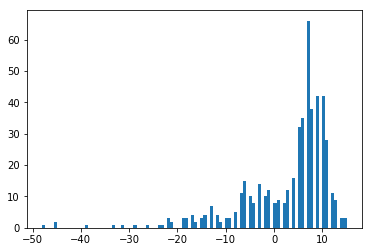

percentile= 70 %
mean reward = 0.70200	threshold = -2.0
rewards above +9.0 is 9.0 %


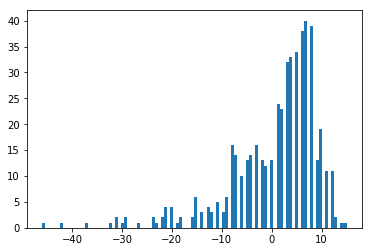

percentile= 80 %
mean reward = -14.63000	threshold = -26.0
rewards above +9.0 is 1.4 %


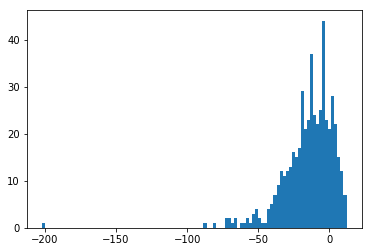

percentile= 90 %
mean reward = -376.04800	threshold = -470.0
rewards above +9.0 is 0.0 %


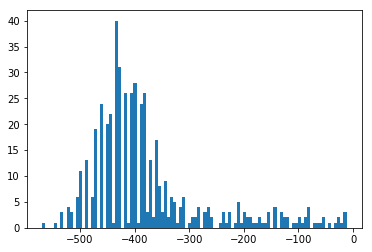

In [32]:
percentiles = [10,20,30,40,50,60,70,80,90]
mean_rewards=[]
thresholds=[]
percentages=[]

for percentile in percentiles:
    n_samples = 500  #sample this many samples
    smoothing = 0.1  #add this thing to all counts for stability
    policy = np.ones((n_states,n_actions))/n_actions #need to reset the policy when changing hyperparameters

    for i in range(30):

        sessions = [generate_session() for i in range(n_samples)]

        batch_states,batch_actions,batch_rewards,timestep = map(np.array,zip(*sessions))

        #batch_states: a list of lists of states in each session
        #batch_actions: a list of lists of actions in each session
        #batch_rewards: a list of floats - total rewards at each session

        threshold = np.percentile(batch_rewards, q=100-percentile)

        elite_states = batch_states[batch_rewards>threshold]
        elite_actions = batch_actions[batch_rewards>threshold]

        elite_states, elite_actions = map(np.concatenate,[elite_states,elite_actions])
        #hint on task above: use np.percentile and numpy-style indexing

        #count actions from elite states
        elite_counts = np.zeros_like(policy)+smoothing

        #<count all state-action occurences in elite_states and elite_actions>
        for state,action in zip(elite_states,elite_actions):
            elite_counts[state,action]+=1.

        #通ったstateだけを更新
        for state in elite_states:
            policy[state] = elite_counts[state] / sum(elite_counts[state])

        #print("mean reward = %.5f\tthreshold = %.1f"%(np.mean(batch_rewards),threshold))

        #show the distribution of rewards
        """if i % 10 == 0 or i == 99:
            print("iteration",i)
            print("mean reward = %.5f\tthreshold = %.1f"%(np.mean(batch_rewards),threshold))
            plt.hist(timestep,bins=100)
            plt.show()"""
    
    print("percentile=",percentile,"%")
    print("mean reward = %.5f\tthreshold = %.1f"%(np.mean(batch_rewards),threshold))
    print("rewards above +9.0 is",(batch_rewards>9.).sum()/len(batch_rewards)*100,"%")
    plt.hist(batch_rewards,bins=100)
    plt.show()
    
    mean_rewards.append(np.mean(batch_rewards))
    thresholds.append(threshold)
    percentages.append((batch_rewards>9.).sum()/len(batch_rewards)*100)

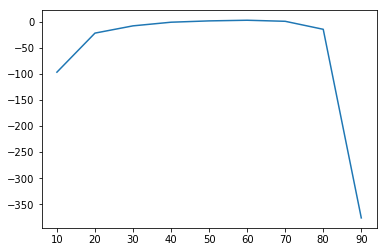

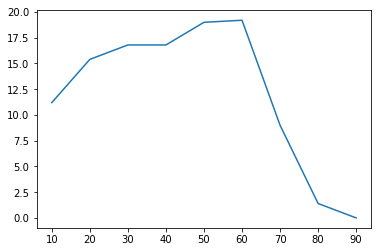

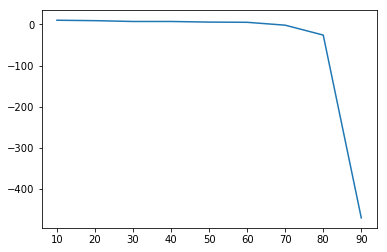

In [35]:
plt.plot(percentiles,mean_rewards)
plt.show()

plt.plot(percentiles,percentages)
plt.show()

plt.plot(percentiles,thresholds)
plt.show()

percentile= 10 %
mean reward = -338.14000	threshold = 6.0
rewards above +9.0 is 5.0 %


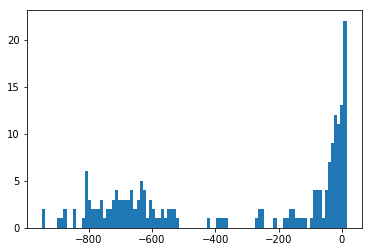

percentile= 20 %
mean reward = -401.67500	threshold = -6.0
rewards above +9.0 is 2.0 %


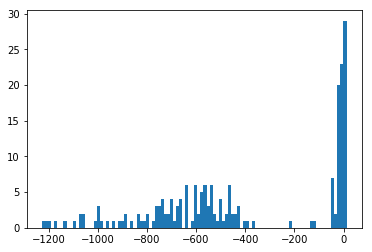

percentile= 30 %
mean reward = -155.99500	threshold = -0.7
rewards above +9.0 is 7.0 %


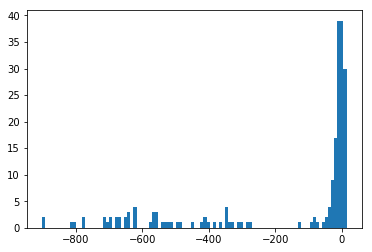

percentile= 40 %
mean reward = -144.95000	threshold = -2.6
rewards above +9.0 is 7.5 %


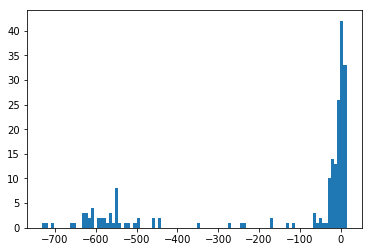

percentile= 50 %
mean reward = -14.90500	threshold = -4.0
rewards above +9.0 is 5.0 %


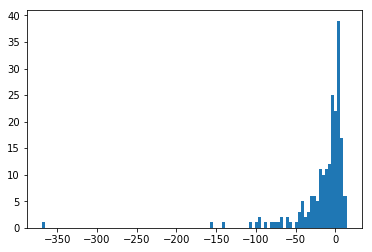

percentile= 60 %
mean reward = -112.34000	threshold = -20.0
rewards above +9.0 is 3.5 %


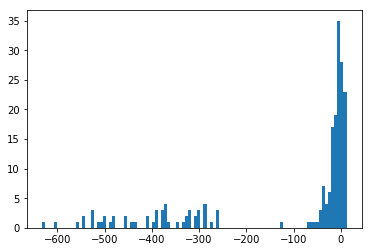

percentile= 70 %
mean reward = -104.85000	threshold = -135.2
rewards above +9.0 is 0.0 %


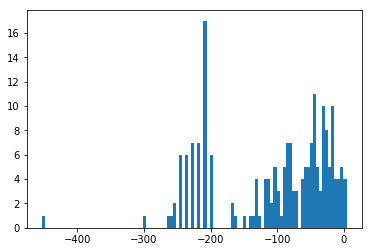

percentile= 80 %
mean reward = -139.64500	threshold = -209.0
rewards above +9.0 is 0.0 %


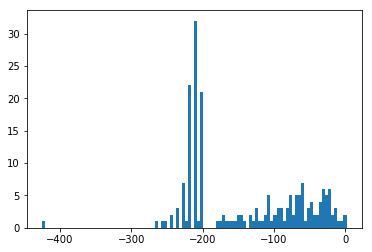

percentile= 90 %
mean reward = -300.38000	threshold = -452.0
rewards above +9.0 is 0.5 %


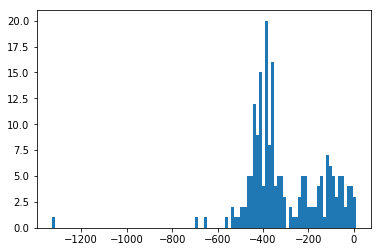

In [34]:
percentiles = [10,20,30,40,50,60,70,80,90]
mean_rewards2=[]
thresholds2=[]
percentages2=[]

for percentile in percentiles:
    n_samples = 200  #sample this many samples
    smoothing = 0.1  #add this thing to all counts for stability
    policy = np.ones((n_states,n_actions))/n_actions #need to reset the policy when changing hyperparameters

    for i in range(30):

        sessions = [generate_session() for i in range(n_samples)]

        batch_states,batch_actions,batch_rewards,timestep = map(np.array,zip(*sessions))

        #batch_states: a list of lists of states in each session
        #batch_actions: a list of lists of actions in each session
        #batch_rewards: a list of floats - total rewards at each session

        threshold = np.percentile(batch_rewards, q=100-percentile)

        elite_states = batch_states[batch_rewards>threshold]
        elite_actions = batch_actions[batch_rewards>threshold]

        elite_states, elite_actions = map(np.concatenate,[elite_states,elite_actions])
        #hint on task above: use np.percentile and numpy-style indexing

        #count actions from elite states
        elite_counts = np.zeros_like(policy)+smoothing

        #<count all state-action occurences in elite_states and elite_actions>
        for state,action in zip(elite_states,elite_actions):
            elite_counts[state,action]+=1.

        #通ったstateだけを更新
        for state in elite_states:
            policy[state] = elite_counts[state] / sum(elite_counts[state])

        #print("mean reward = %.5f\tthreshold = %.1f"%(np.mean(batch_rewards),threshold))

        #show the distribution of rewards
        """if i % 10 == 0 or i == 99:
            print("iteration",i)
            print("mean reward = %.5f\tthreshold = %.1f"%(np.mean(batch_rewards),threshold))
            plt.hist(timestep,bins=100)
            plt.show()"""
    
    print("percentile=",percentile,"%")
    print("mean reward = %.5f\tthreshold = %.1f"%(np.mean(batch_rewards),threshold))
    print("rewards above +9.0 is",(batch_rewards>9.).sum()/len(batch_rewards)*100,"%")
    plt.hist(batch_rewards,bins=100)
    plt.show()
    
    mean_rewards2.append(np.mean(batch_rewards))
    thresholds2.append(threshold)
    percentages2.append((batch_rewards>9.).sum()/len(batch_rewards)*100)

mean


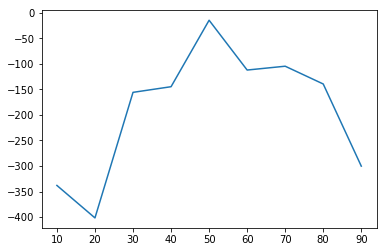

per


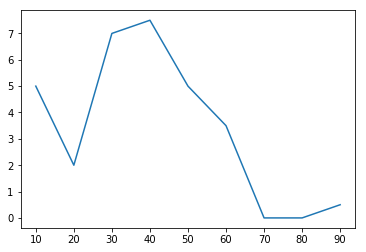

thre


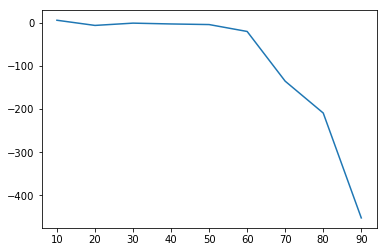

In [36]:
print("mean")
plt.plot(percentiles,mean_rewards2)
plt.show()

print("per")
plt.plot(percentiles,percentages2)
plt.show()

print("thre")
plt.plot(percentiles,thresholds2)
plt.show()

percentile= 10 %
mean reward = -35.71300	threshold = 10.0
rewards above +9.0 is 12.4 %


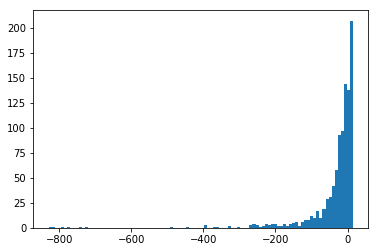

percentile= 20 %
mean reward = -6.32900	threshold = 10.0
rewards above +9.0 is 20.1 %


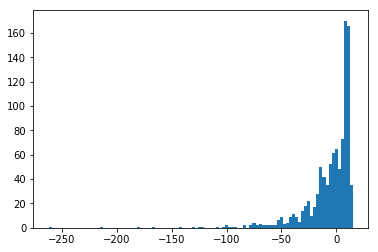

percentile= 30 %
mean reward = -0.04700	threshold = 9.0
rewards above +9.0 is 23.2 %


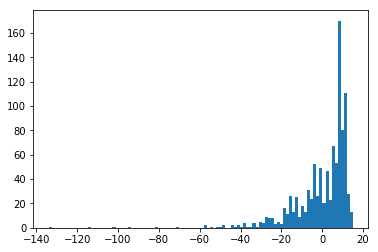

percentile= 40 %
mean reward = 1.14700	threshold = 8.0
rewards above +9.0 is 24.3 %


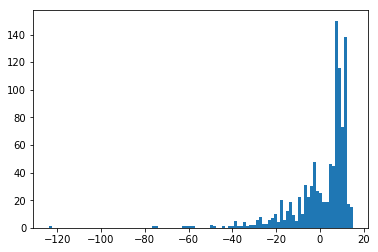

percentile= 50 %
mean reward = 3.95800	threshold = 8.0
rewards above +9.0 is 28.3 %


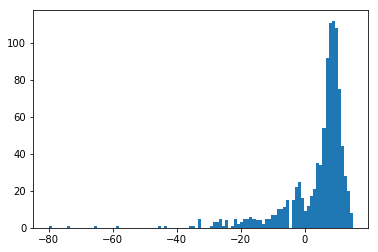

percentile= 60 %
mean reward = 5.17900	threshold = 7.0
rewards above +9.0 is 26.4 %


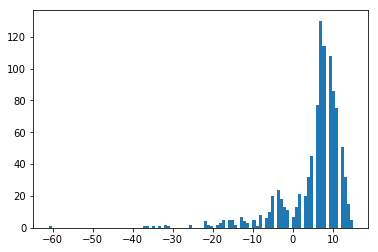

percentile= 70 %
mean reward = 5.24900	threshold = 5.0
rewards above +9.0 is 20.9 %


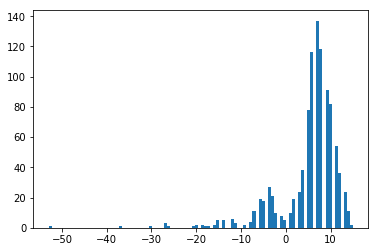

percentile= 80 %
mean reward = -7.78400	threshold = -16.0
rewards above +9.0 is 3.8 %


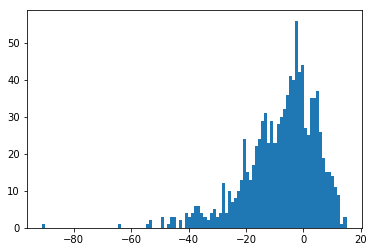

percentile= 90 %
mean reward = -219.65300	threshold = -389.0
rewards above +9.0 is 0.1 %


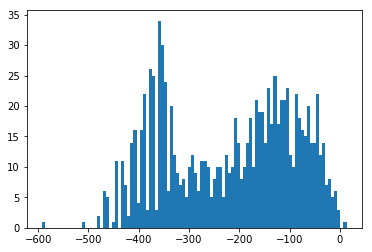

In [37]:
percentiles = [10,20,30,40,50,60,70,80,90]
mean_rewards3=[]
thresholds3=[]
percentages3=[]

for percentile in percentiles:
    n_samples = 1000  #sample this many samples
    smoothing = 0.1  #add this thing to all counts for stability
    policy = np.ones((n_states,n_actions))/n_actions #need to reset the policy when changing hyperparameters

    for i in range(30):

        sessions = [generate_session() for i in range(n_samples)]

        batch_states,batch_actions,batch_rewards,timestep = map(np.array,zip(*sessions))

        #batch_states: a list of lists of states in each session
        #batch_actions: a list of lists of actions in each session
        #batch_rewards: a list of floats - total rewards at each session

        threshold = np.percentile(batch_rewards, q=100-percentile)

        elite_states = batch_states[batch_rewards>threshold]
        elite_actions = batch_actions[batch_rewards>threshold]

        elite_states, elite_actions = map(np.concatenate,[elite_states,elite_actions])
        #hint on task above: use np.percentile and numpy-style indexing

        #count actions from elite states
        elite_counts = np.zeros_like(policy)+smoothing

        #<count all state-action occurences in elite_states and elite_actions>
        for state,action in zip(elite_states,elite_actions):
            elite_counts[state,action]+=1.

        #通ったstateだけを更新
        for state in elite_states:
            policy[state] = elite_counts[state] / sum(elite_counts[state])

        #print("mean reward = %.5f\tthreshold = %.1f"%(np.mean(batch_rewards),threshold))

        #show the distribution of rewards
        """if i % 10 == 0 or i == 99:
            print("iteration",i)
            print("mean reward = %.5f\tthreshold = %.1f"%(np.mean(batch_rewards),threshold))
            plt.hist(timestep,bins=100)
            plt.show()"""
    
    print("percentile=",percentile,"%")
    print("mean reward = %.5f\tthreshold = %.1f"%(np.mean(batch_rewards),threshold))
    print("rewards above +9.0 is",(batch_rewards>9.).sum()/len(batch_rewards)*100,"%")
    plt.hist(batch_rewards,bins=100)
    plt.show()
    
    mean_rewards3.append(np.mean(batch_rewards))
    thresholds3.append(threshold)
    percentages3.append((batch_rewards>9.).sum()/len(batch_rewards)*100)

mean


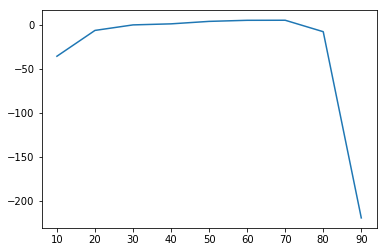

per


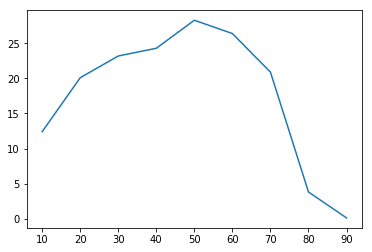

thre


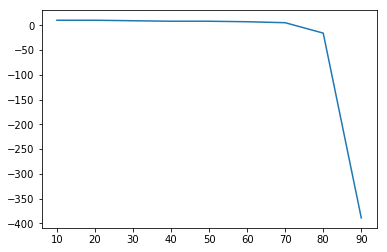

In [38]:
print("mean")
plt.plot(percentiles,mean_rewards3)
plt.show()

print("per")
plt.plot(percentiles,percentages3)
plt.show()

print("thre")
plt.plot(percentiles,thresholds3)
plt.show()

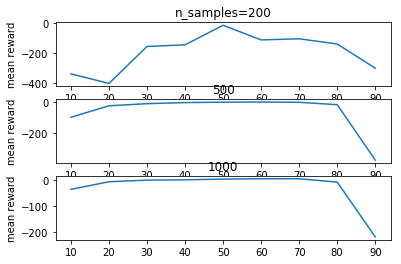

In [70]:
plt.subplot(3,1,1)
plt.plot(percentiles,mean_rewards2)
plt.title("n_samples=200")
plt.ylabel("mean reward")

plt.subplot(3,1,2)
plt.plot(percentiles,mean_rewards)
plt.title("500")
plt.ylabel("mean reward")

plt.subplot(3,1,3)
plt.plot(percentiles,mean_rewards3)
plt.title("1000")
plt.ylabel("mean reward")

plt.show()

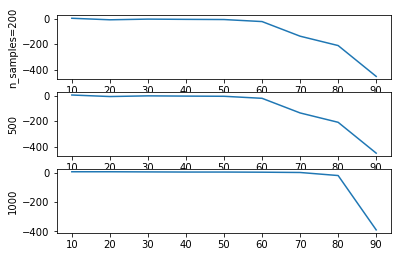

In [69]:
plt.subplot(3,1,1)
plt.plot(percentiles,thresholds2)
plt.ylabel("n_samples=200")
plt.ylabel("threshold")

plt.subplot(3,1,2)
plt.plot(percentiles,thresholds2)
plt.ylabel("500")
plt.ylabel("mean reward")

plt.subplot(3,1,3)
plt.plot(percentiles,thresholds3)
plt.ylabel("1000")
plt.ylabel("mean reward")

plt.show()

# Homework

### Tabular correntropy method

You may have noticed that the taxi problem quickly converges from -10k to aroung -500 score (+- 500) and stays there. This is in part because taxi-v2 has some hard-coded randomness in the environment. Other reason is that the percentile was chosen poorly.

### Tasks
- __1.1__ (5 pt) Modify the tabular CEM (CrossEntropyMethod) code to plot distribution of rewards and threshold on each tick.
- __1.2__ (5 pts) Find out how the algorithm performance changes if you change different percentile and different n_samples.

```<YOUR ANSWER>```


- __1.3__ (10 pts) Tune the algorithm to end up with positive average score.
- __1.4 bonus__ (10 pt) Try to achieve a distribution where 25% or more samples score above +9.0

It's okay to modify the existing code.
